<a href="https://colab.research.google.com/github/riverdogcabin/PSDS4900/blob/main/wu_observation_stats_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
from pprint import pprint
import json

In [ ]:
with open('/content/drive/MyDrive/Capstone/PSDS4900/config.json') as configuration:
  my_station = json.load(configuration).get('WU')["stationid"] #'WU' is the parameters for WeatherUnderground

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/PSDS4900/wu_data/wu_observations.csv')
print('with dupes',df.shape)
before = df.shape[0]
df.drop_duplicates(inplace=True)
print('without dupes',df.shape)
print('difference: ',before-df.shape[0])

with dupes (19504, 32)
without dupes (19504, 32)
difference:  0


In [ ]:
# create a timestamp timeseries column for use later based on the epoc values 
df['timestamp'] = pd.to_datetime(df['epoch'], unit='s')

In [ ]:
# filtered = df[(df['timestamp']>=pd.Timestamp(2021,3,22)) & (df['timestamp']<pd.Timestamp(2021,3,23)) & (df.stationID == my_station)] 
# # filtered = df[(df['timestamp'] == pd.Timestamp(2021,3,22)) & (df.stationID == my_station)]
# # df[df.stationID==my_station & df.timestamp < '2021-03-22' & df.timestamp >= '2021-03-21'].head()
# filtered

In [ ]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(20,7), title=None, show_legend=True):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.
    obtained from https://stackoverflow.com/questions/30942755/plotting-multiple-time-series-after-a-groupby-in-pandas and modified slightly
    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    xtick_locator = DayLocator(interval=1)
    xtick_dateformatter = DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='o')
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    if(not show_legend):
      ax.get_legend().remove()
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(0, df[value_name].max() * 1.25)
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

In [ ]:
num_stations = len(df.stationID.unique())
num_stations #number of unique stations in the sample

85

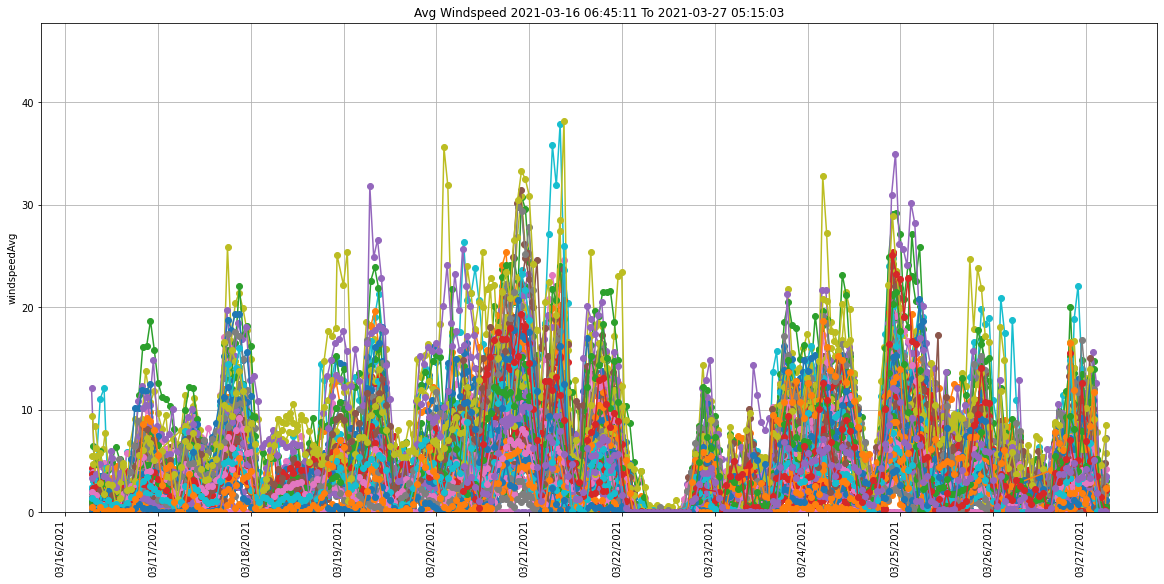

In [ ]:
# let's see what everything looks like - bit of a mess but you can sort of see some trends
plot_gb_time_series(df, 'timestamp', 'stationID', 'windspeedAvg',
                    figsize=(20, 10), title="Avg Windspeed {} To {}".format(df.timestamp.min(),df.timestamp.max()), show_legend=False)

In [ ]:
df.windspeedAvg.describe()

count    19504.000000
mean         4.128061
std          4.589751
min          0.000000
25%          0.500000
50%          2.800000
75%          6.025000
max         38.200000
Name: windspeedAvg, dtype: float64

## Now I need to look through the data to see what the right time grouping is. The weather stations each report at their individual second on the hour, so we need to pull them together (group) so we can compare the observations that are the closest in time amongst the different weather stations.

## When we do that it is possible that there will be some groups that do not contain my_station so we can't identify correlations for those groups unless we do some oversampling or something that I'm not ready to attempt just yet.

In [ ]:
groupings = {}
contains_my_station = {}
intervals = ['5min','10min','15min','20min','30min','45min','60min']
for r in intervals:
  df = df.assign(timestamp_rounded=df.timestamp.dt.round(r)) # 'min' to round to nearest minute
  grouped = df.groupby(['timestamp_rounded'])
  counter = 0
  for g in grouped.groups:
      s = grouped.get_group(g)[grouped.get_group(g).stationID.str.find(my_station)>-1].shape[0]
      # print(g,' : ',s)
      if(s > 0):
        counter += 1
  contains_my_station[r] = [counter,len(grouped.groups),(counter/len(grouped.groups))]
  groupings[r] = grouped.count().reset_index()

In [ ]:
pd.DataFrame(contains_my_station).rename(index={0:'My Station Present',1:'Total Groups',2:'Percent Groups Containing My Station'})

,5min,10min,15min,20min,30min,45min,60min
My Station Present,266.000000,265.000000,265.000000,264.000000,263.00000,263.000000,263.0
Total Groups,880.000000,590.000000,577.000000,540.000000,314.00000,351.000000,263.0
Percent Groups Containing My Station,0.302273,0.449153,0.459272,0.488889,0.83758,0.749288,1.0


## If we round to the nearest 30 minutes then 83.76% of the groups contain my station and if we round to the nearest 60 minutes and group then 100% of the groups have my station providing an observation. Those are the two groupings to keep an eye on.

## Let's generate some descriptive stats for each of the groupings:

In [ ]:
for r in intervals:
  print(r,'\n',groupings[r][['stationID','humidityAvg','windspeedAvg','windgustAvg','tempAvg']].describe(),'\n')

5min 
         stationID  humidityAvg  windspeedAvg  windgustAvg     tempAvg
count  880.000000   880.000000    880.000000   880.000000  880.000000
mean    22.163636    22.163636     22.163636    22.163636   22.163636
std     27.738754    27.738754     27.738754    27.738754   27.738754
min      1.000000     1.000000      1.000000     1.000000    1.000000
25%      4.000000     4.000000      4.000000     4.000000    4.000000
50%      7.000000     7.000000      7.000000     7.000000    7.000000
75%     46.000000    46.000000     46.000000    46.000000   46.000000
max     81.000000    81.000000     81.000000    81.000000   81.000000 

10min 
         stationID  humidityAvg  windspeedAvg  windgustAvg     tempAvg
count  590.000000   590.000000    590.000000   590.000000  590.000000
mean    33.057627    33.057627     33.057627    33.057627   33.057627
std     34.361358    34.361358     34.361358    34.361358   34.361358
min      1.000000     1.000000      1.000000     1.000000    1.000000
25%

## Looking at the descriptive stats above, it appears that the variance in the counts of values in the 30 minute grouping is pretty high. There are between 55 and 85 stations in the data depending on the time range (since I added more stations a couple of days after the first ingest). I know that most of the weather stations are *supposed* to report readings hourly. I will need to account for the max value because it is so high (167) but the deviation seems tolerable.

## Performing a more visual inspection of the counts to see if anything jumps out at me and so I can make a final decision on the right time grouping.

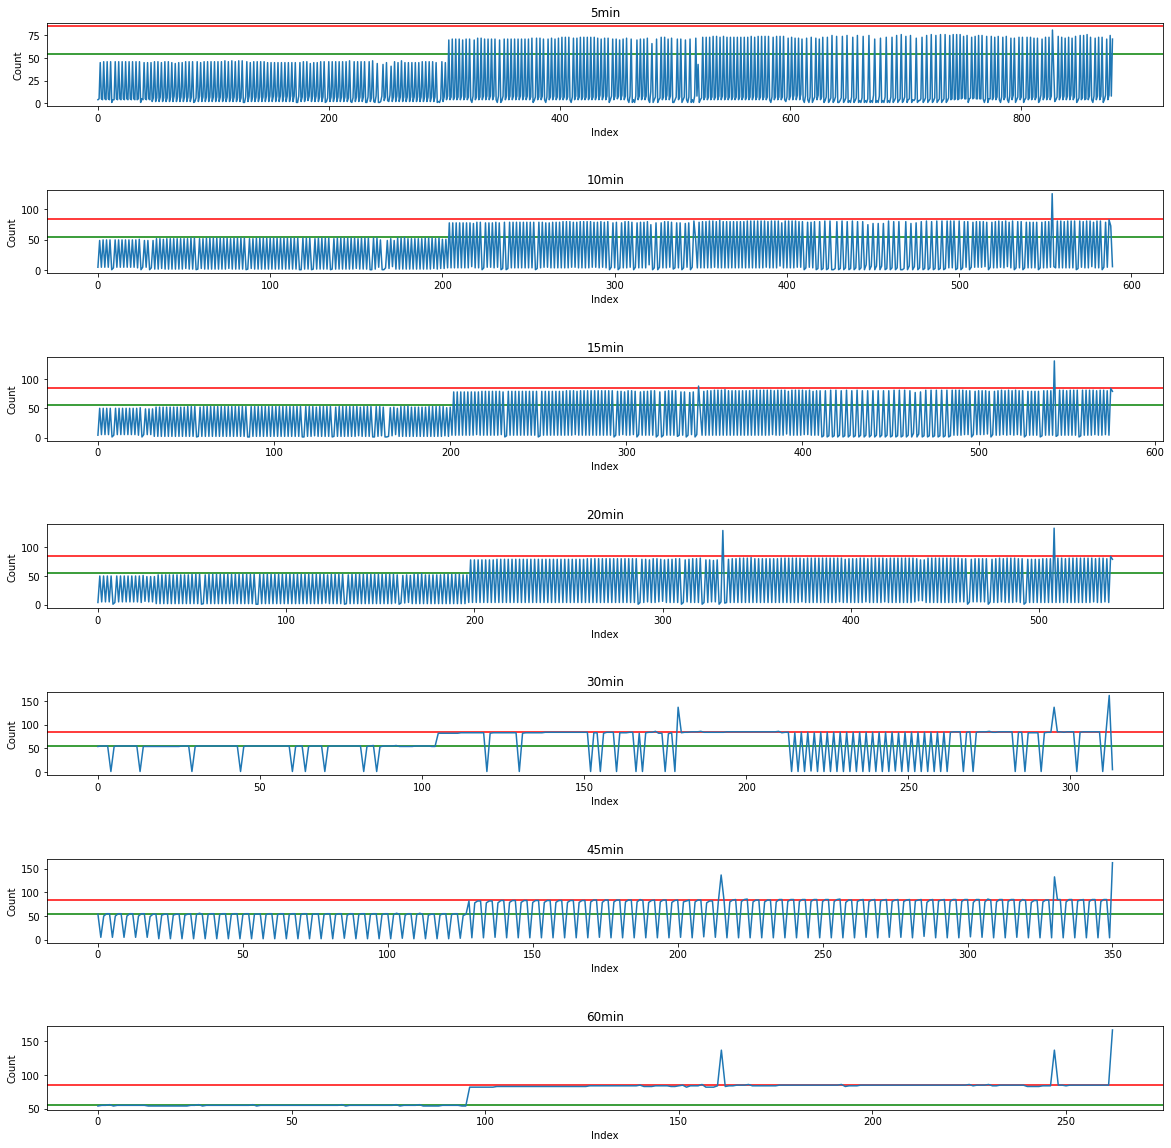

In [ ]:
fig, axs = plt.subplots(len(intervals),figsize=(20, 20))
plt.subplots_adjust(hspace=1)
for i in range(len(intervals)):
  axs[i].set_title(intervals[i])
  axs[i].set_xlabel('Index')
  axs[i].set_ylabel('Count')
  axs[i].axhline(y=num_stations,color='red')
  axs[i].axhline(y=55,color='green')
  groupings[intervals[i]].windspeedAvg.plot(ax=axs[i])


## We see how flat/even the counts become when rounding to the hour, except for a couple of small spikes and the large uptick at the end. Grouping to 30 minutes still does fairly well as most indices plateau at around 55 (for the first batch of data) or 85 (for the second batch of data) but not as well as the 60 minute grouping. The 60 minute grouping maximizes both the representation of my station and the other stations in the data.

## Let's see if we can ID the hours that are spiking.

In [ ]:
groupings['60min'].sort_values('stationID').tail()

,timestamp_rounded,stationID,epoch,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,qcStatus,tempHigh,tempLow,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptHigh,dewptLow,dewptAvg,windchillHigh,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal,timestamp
230,2021-03-25 21:00:00,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
168,2021-03-23 07:00:00,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
161,2021-03-23 00:00:00,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137
247,2021-03-26 14:00:00,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137
262,2021-03-27 05:00:00,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167


In [ ]:
hour_grouping_std = groupings['60min'].stationID.std()
# hour_grouping_std

In [ ]:
df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) #just to make sure timestamp_rounded is rounded by the hour
problem_hours = list(groupings['60min'][groupings['60min'].stationID > num_stations+hour_grouping_std].timestamp_rounded) #get all groups that are more than one standard deviation off the station count
problem_hours_df = df[df.timestamp_rounded.isin(problem_hours)][['stationID','timestamp_rounded','epoch']]#.set_index('stationID',drop=False)
pd.options.display.max_rows = 100 #so we can show the whole dataframe
problem_hours_df.pivot_table(index='timestamp_rounded',columns='stationID',values='epoch',aggfunc='count').T


timestamp_rounded,2021-03-23 00:00:00,2021-03-26 14:00:00,2021-03-27 05:00:00
stationID,,,
KCOCASTL148,2.0,2.0,2.0
KCOCASTL161,2.0,2.0,2.0
KCOCASTL167,1.0,1.0,2.0
KCOCASTL195,2.0,2.0,2.0
KCOCASTL200,2.0,2.0,2.0
KCOCASTL204,2.0,2.0,2.0
KCOCASTL205,2.0,1.0,2.0
KCOCASTL208,2.0,2.0,2.0
KCOCASTL227,2.0,2.0,2.0


## it appears that every single station has two observations in the 2021-03-27 05:00:00 time group and many have two observations in the 2021-03-23 00:00:00	and 2021-03-26 14:00:00 groups. Let's pull some of the data to see why that is.

In [ ]:
df[(df.timestamp_rounded.isin(problem_hours)) & (df.stationID.isin(['KCOCASTL148',my_station]))][['stationID','timestamp','timestamp_rounded']].sort_values('timestamp')

,stationID,timestamp,timestamp_rounded
161,KCOCASTL148,2021-03-22 23:59:52,2021-03-23 00:00:00
17060,KCOPARKE414,2021-03-22 23:59:53,2021-03-23 00:00:00
17061,KCOPARKE414,2021-03-23 00:09:45,2021-03-23 00:00:00
162,KCOCASTL148,2021-03-23 00:09:46,2021-03-23 00:00:00
248,KCOCASTL148,2021-03-26 13:59:51,2021-03-26 14:00:00
17147,KCOPARKE414,2021-03-26 13:59:55,2021-03-26 14:00:00
249,KCOCASTL148,2021-03-26 14:04:56,2021-03-26 14:00:00
17148,KCOPARKE414,2021-03-26 14:04:59,2021-03-26 14:00:00
264,KCOCASTL148,2021-03-27 04:59:34,2021-03-27 05:00:00
17163,KCOPARKE414,2021-03-27 04:59:54,2021-03-27 05:00:00


## The problem seems to be that for some stations there are two observations that round to the hour: one just prior to midnight (zulu) and one just after midnight. I am unsure why the stations did that. We will need to drop the extra reading for this hour grouping. It appears that even my station is duplicated so when we filter out the extra observations we will also purge the extra observation for my station which is good.

In [ ]:
indices_to_drop = df[(df.timestamp_rounded.isin(problem_hours)) & (df.timestamp > df.timestamp_rounded)].index
df.drop(indices_to_drop,inplace=True)

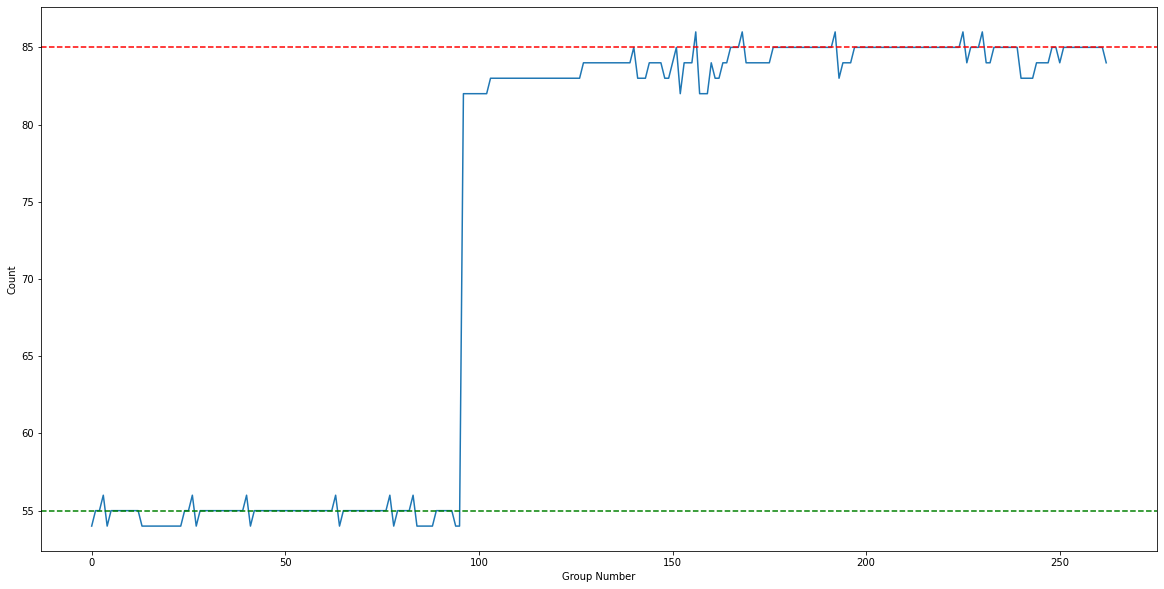

In [ ]:
# df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) # 'min' to round to nearest minute
grouped = df.groupby(['timestamp_rounded'])
ax = grouped.count().reset_index().windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=55,color='green',linestyle='--')
ax.axhline(y=num_stations,color='red',linestyle='--')

## It looks less awesome when we are zoomed in so much, but we can see that we have removed the extra observations that caused the spikes and most of the data is within one or two stations of the expected (either 55 or 85).

In [ ]:
# let's make sure I have my_station in each of the groupings
counter = 0
for g in grouped.groups:
    s = grouped.get_group(g)[grouped.get_group(g).stationID.str.find(my_station)>-1].shape[0]
    if(s > 0):
      counter += 1
print('num groups with my_station: {}\ntotal num of groups: {}\n{:0.2f}%'.format(counter,len(grouped.groups),(counter/len(grouped.groups)*100)))

num groups with my_station: 263
total num of groups: 263
100.00%


Now that we have aligned the data (as well as we can, anyway) we need to start looking for stations that have reading that are correlated to the readings from my station. Let's start with the "Avg" columns. 

In [ ]:
columns_to_check = [s for s in df.columns if "Avg" in s]
columns_to_check

['winddirAvg',
 'humidityAvg',
 'tempAvg',
 'windspeedAvg',
 'windgustAvg',
 'dewptAvg',
 'windchillAvg',
 'heatindexAvg']

In [ ]:
corr_df = pd.DataFrame({'stationID':df.stationID.unique()}) #create the shell of the dataframe to store the correlations
max_correlations = {} #this will hold the maximally correlated stations for each variable
for v in columns_to_check:
  #create a pivot table for each variable
  temp_df = df.pivot_table(index='timestamp_rounded',columns='stationID',values=v).corr()[[my_station]]
  temp_df.columns.name = None #get rid of the column names and then collapse the indices, reindex and rename the columns
  temp_df = temp_df.stack().reset_index().drop(columns='level_1').rename(columns={0:v+'_corr'})
  #get rid of the results for my_station, obvs 
  temp_df = temp_df[temp_df.stationID != my_station]
  #collect the maximally correlated station for the variable
  max_correlations[v] = temp_df.loc[temp_df[v+'_corr'].abs().idxmax()].to_list()
  #add all the corrleations for this variable as a column to the big correlation dataframe
  corr_df = corr_df.merge(temp_df,on='stationID')
corr_df.head()

,stationID,winddirAvg_corr,humidityAvg_corr,tempAvg_corr,windspeedAvg_corr,windgustAvg_corr,dewptAvg_corr,windchillAvg_corr,heatindexAvg_corr
0,KCOCASTL148,0.067761,-0.173118,0.978252,0.238619,0.374928,-0.202981,0.960867,0.978252
1,KCOCASTL161,0.287027,0.414394,0.977812,0.689029,0.717761,0.492786,0.966638,0.977812
2,KCOCASTL167,0.153775,0.962788,0.977974,0.721546,0.743041,0.939140,0.946307,0.977975
3,KCOCASTL195,0.154724,0.968065,0.970225,0.552424,0.601572,0.776115,0.972038,0.970041
4,KCOCASTL200,-0.030708,0.969714,0.983946,0.664682,0.700990,0.935383,0.975291,0.983946


In [ ]:
pd.DataFrame(max_correlations).T.rename(columns={0:'Station',1:'Correlation Score'})

,Station,Correlation Score
winddirAvg,KCOPARKE148,0.613229
humidityAvg,KCOPARKE374,0.993396
tempAvg,KCOPARKE313,0.993265
windspeedAvg,KCOPARKE331,0.829627
windgustAvg,KCOPARKE320,0.847422
dewptAvg,KCOPARKE331,0.983319
windchillAvg,KCOPARKE320,0.990381
heatindexAvg,KCOPARKE313,0.993265


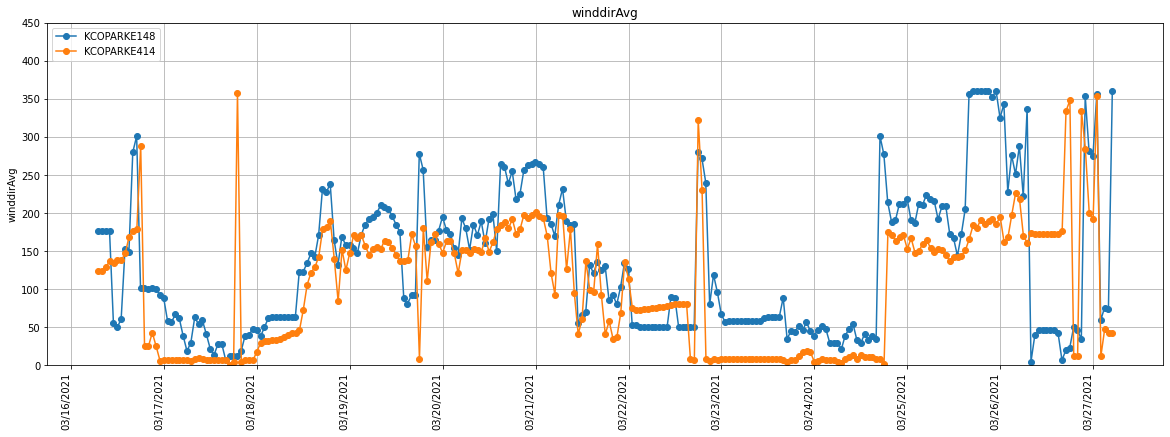

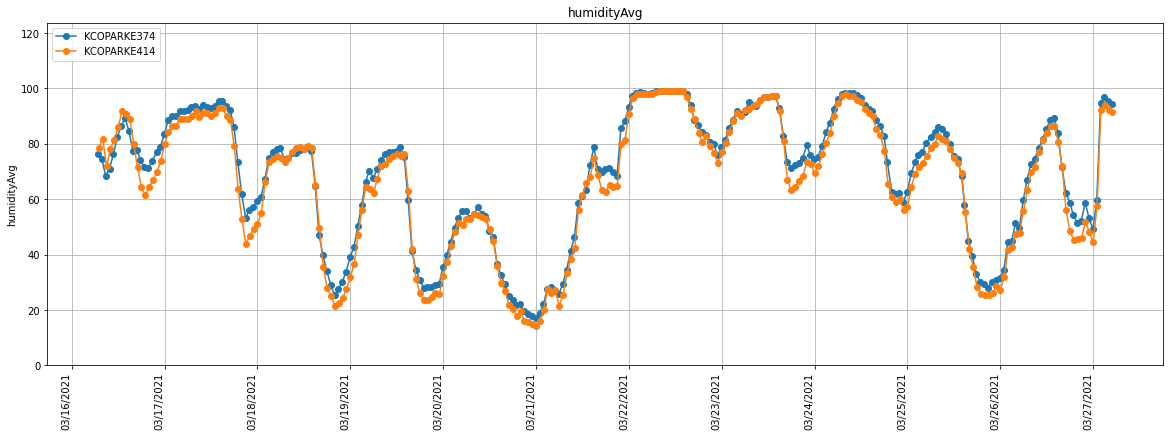

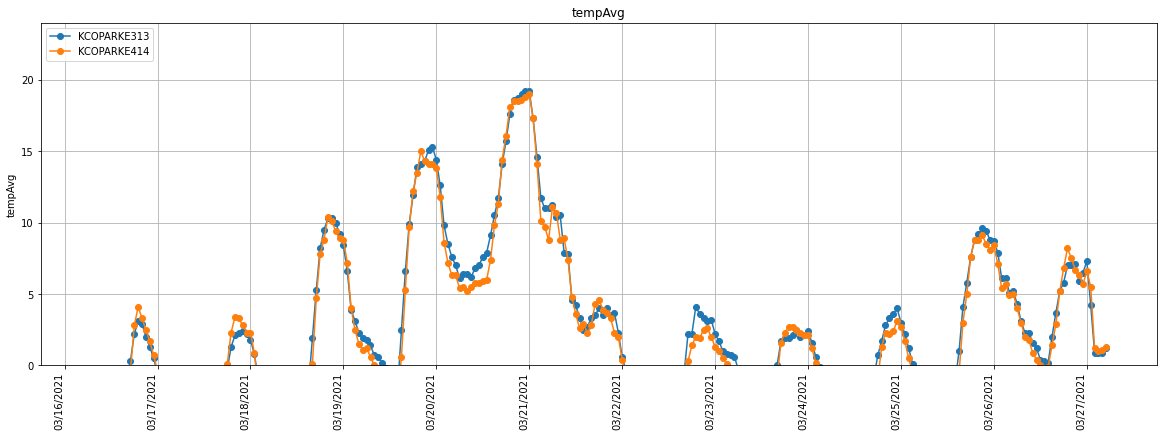

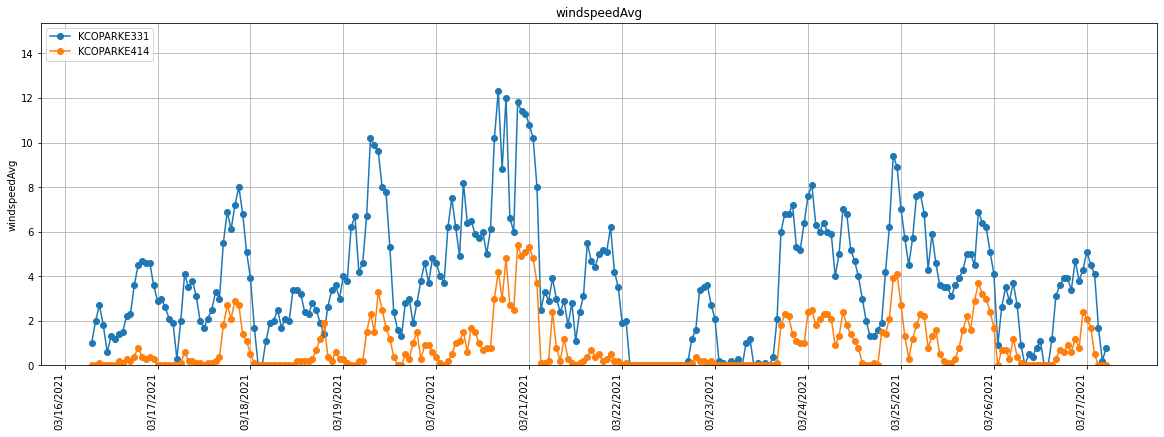

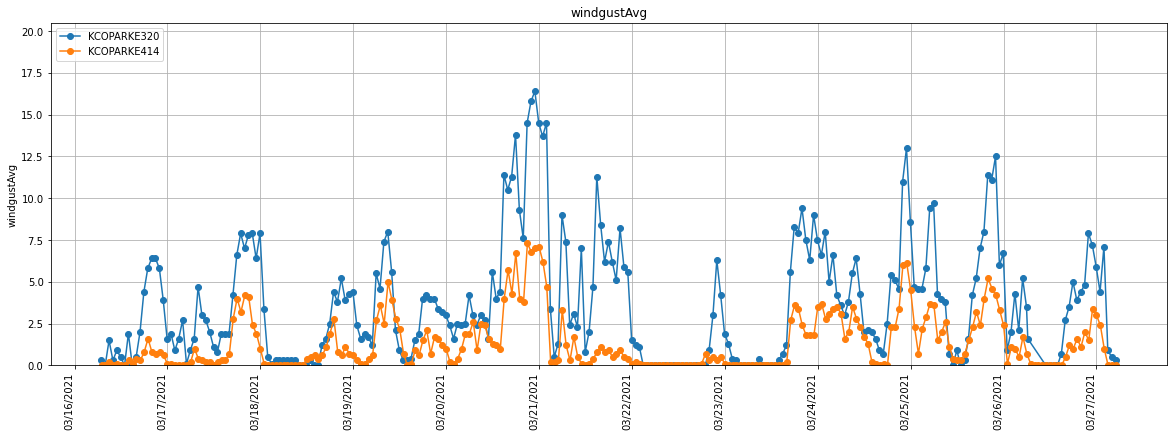

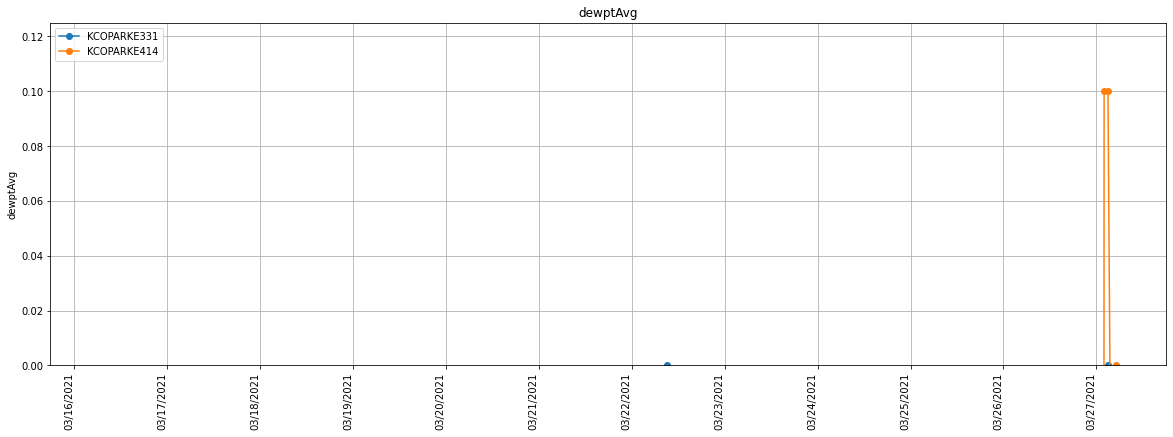

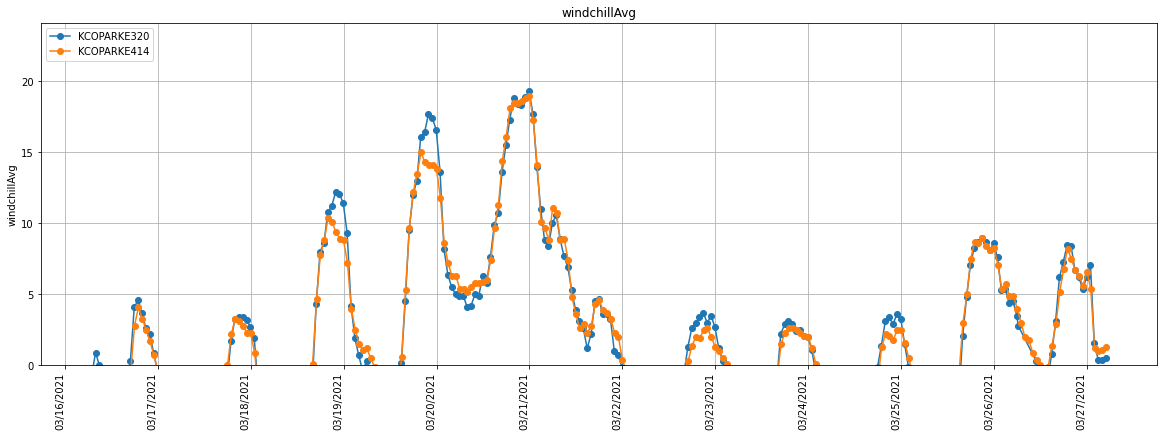

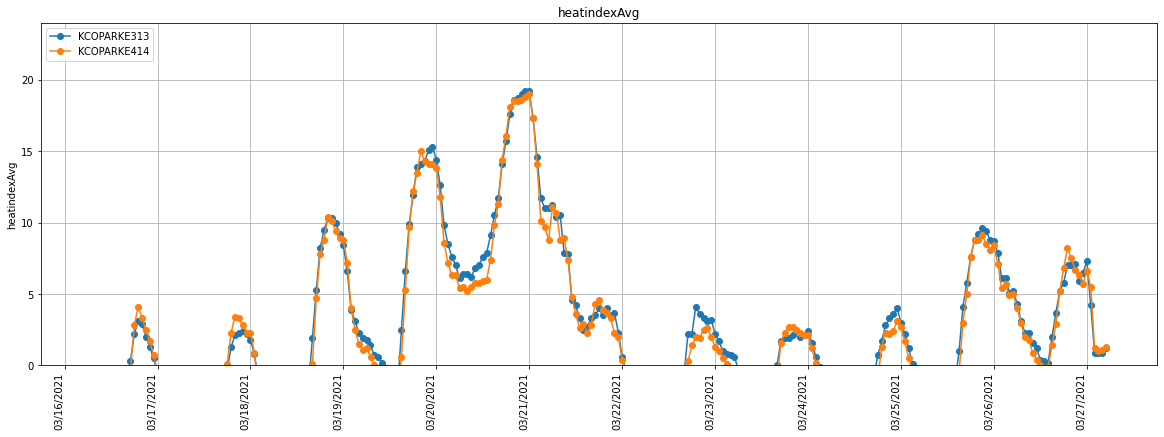

In [ ]:
# fig, axs = plt.subplots(len(max_correlations.keys()),figsize=(20, 20))
i = 0
for k,v in max_correlations.items():
  # print(k,v)
  # axs[i] = 
  plot_gb_time_series(df[df.stationID.isin([my_station,max_correlations[k][0]])], 'timestamp', 'stationID', k, title=k)
  i += 1
# plt.show()

### Now let's take a look at the data in the columns

In [ ]:
numeric_cols = []
for col in df.columns:
  if(is_numeric_dtype(df[col])):
    numeric_cols.append(col)

numeric_cols.remove('epoch') #numeric timestamp which is not something we need to plot or summarize


In [ ]:
df[numeric_cols].describe()

,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,qcStatus,tempHigh,tempLow,tempAvg,windspeedHigh,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,dewptHigh,dewptLow,dewptAvg,windchillHigh,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal
count,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,1.931400e+04
mean,157.863545,1.350782,173.694315,67.166563,61.213783,64.225960,0.659470,3.246484,1.911028,2.560842,9.406115,1.179305,4.157616,12.308911,2.633225,6.406959,-4.502226,-5.866009,-5.186564,3.005825,0.291162,1.838806,3.245128,1.908771,2.558046,997.852006,997.196728,0.012238,0.107752,8.831201e+02
std,275.777881,2.488855,105.363017,25.490425,26.265285,25.854769,0.720197,5.847442,5.513782,5.657815,7.878097,2.616607,4.599296,14.256459,11.560550,12.392954,6.365139,6.668393,6.456864,5.925057,6.077855,5.895206,5.860558,5.506203,5.648631,102.905341,102.838899,0.560254,0.807352,4.335652e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-11.800000,-23.700000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-54.300000,-54.900000,-54.300000,-13.600000,-31.700000,-14.100000,-11.800000,-23.700000,-12.000000,0.000000,0.000000,-6.110000,0.000000,0.000000e+00
25%,0.000000,0.000000,90.000000,52.000000,43.000000,47.525000,1.000000,-1.100000,-1.900000,-1.600000,3.500000,0.000000,0.600000,5.000000,0.000000,1.200000,-5.300000,-7.100000,-6.200000,-1.400000,-3.700000,-2.300000,-1.100000,-1.900000,-1.600000,1006.030000,1005.420000,-0.340000,0.000000,0.000000e+00
50%,0.000000,0.000000,174.000000,73.000000,65.000000,69.400000,1.000000,2.100000,0.700000,1.300000,7.900000,0.000000,2.800000,11.100000,0.000000,4.400000,-3.300000,-4.400000,-3.900000,1.700000,-0.700000,0.400000,2.100000,0.700000,1.300000,1011.140000,1010.500000,0.000000,0.000000,0.000000e+00
75%,214.700000,2.000000,253.000000,88.000000,82.000000,85.100000,1.000000,6.600000,4.775000,5.600000,13.700000,1.400000,6.100000,17.700000,3.200000,9.200000,-1.900000,-2.800000,-2.400000,6.400000,3.200000,4.900000,6.600000,4.775000,5.600000,1016.260000,1015.580000,0.340000,0.000000,0.000000e+00
max,2367.800000,15.000000,360.000000,100.000000,100.000000,100.000000,1.000000,42.700000,22.500000,22.700000,68.100000,27.400000,38.200000,848.000000,848.000000,848.000000,13.300000,10.700000,11.300000,42.700000,22.500000,22.700000,87.500000,21.200000,21.500000,1037.930000,1037.590000,4.070000,34.800000,2.130710e+06


### That's a little busy, let's focus on our "Avg" columns again

In [ ]:
df[columns_to_check].describe()

,winddirAvg,humidityAvg,tempAvg,windspeedAvg,windgustAvg,dewptAvg,windchillAvg,heatindexAvg
count,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000,19314.000000
mean,173.694315,64.225960,2.560842,4.157616,6.406959,-5.186564,1.838806,2.558046
std,105.363017,25.854769,5.657815,4.599296,12.392954,6.456864,5.895206,5.648631
min,0.000000,0.000000,-12.000000,0.000000,0.000000,-54.300000,-14.100000,-12.000000
25%,90.000000,47.525000,-1.600000,0.600000,1.200000,-6.200000,-2.300000,-1.600000
50%,174.000000,69.400000,1.300000,2.800000,4.400000,-3.900000,0.400000,1.300000
75%,253.000000,85.100000,5.600000,6.100000,9.200000,-2.400000,4.900000,5.600000
max,360.000000,100.000000,22.700000,38.200000,848.000000,11.300000,22.700000,21.500000


### Let's see what the distributions look like

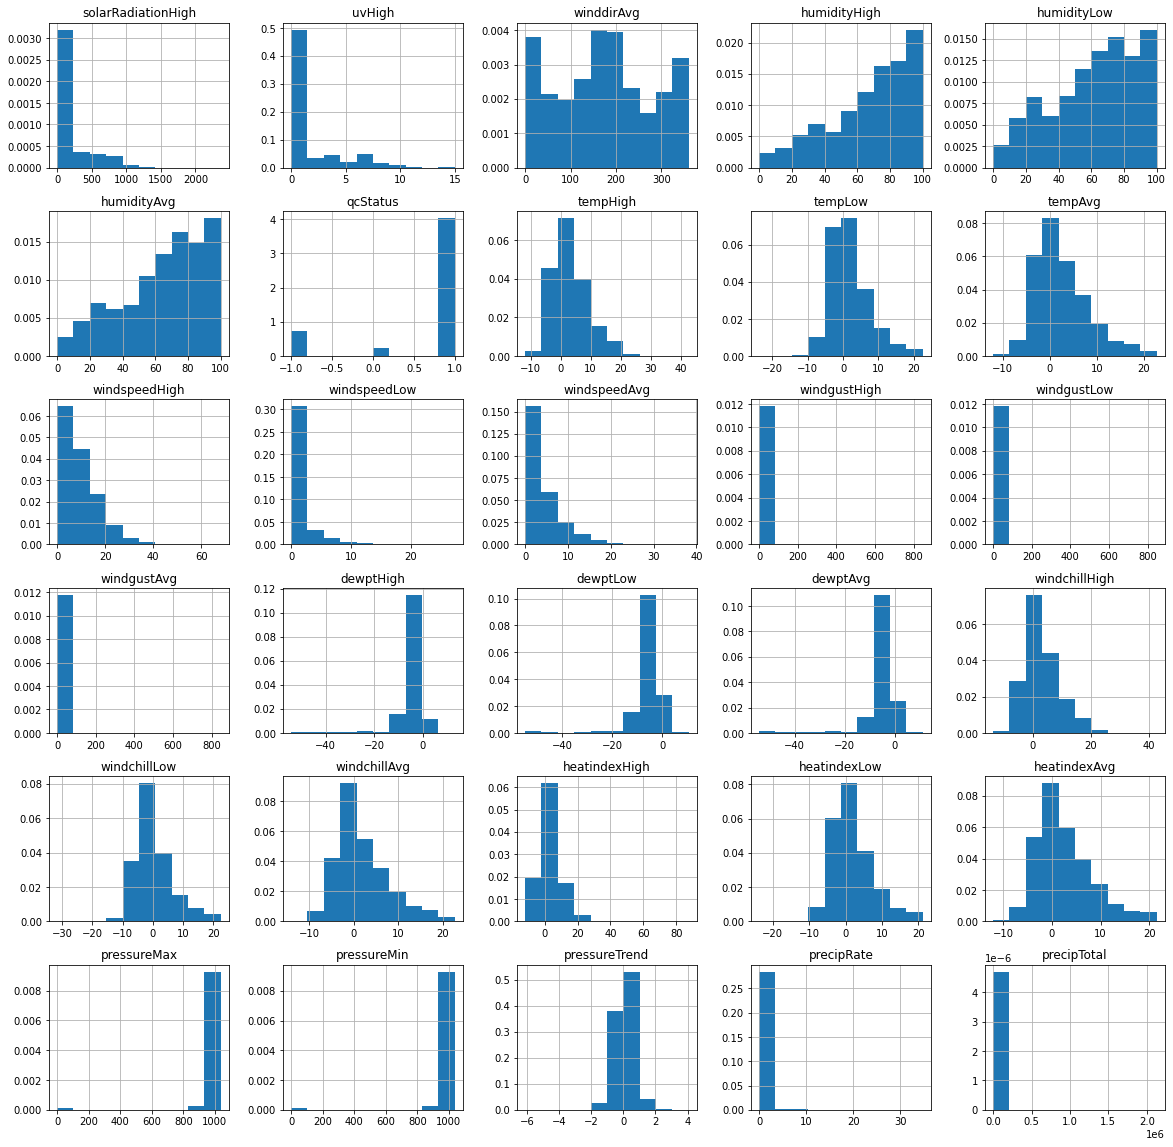

In [ ]:
n = df.drop(columns='epoch').hist(figsize=(20,20),density=True)

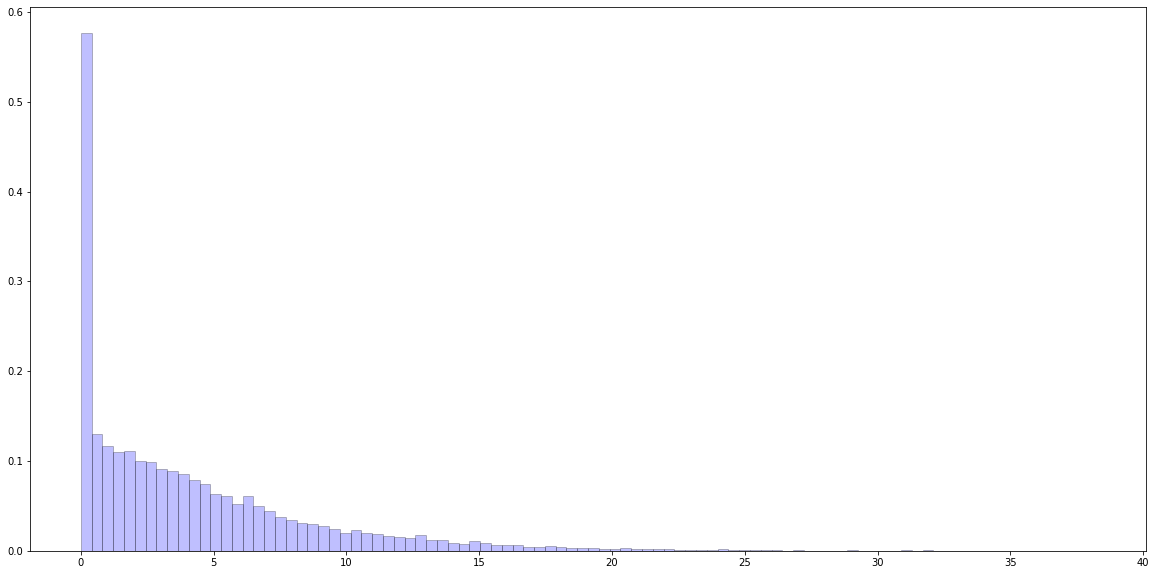

In [ ]:
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(df.windspeedAvg, density=True, bins='auto', facecolor='blue', alpha=0.25, edgecolor="k")

### So that looks like it's possibly a log norm distribution. Let's see if we can fit a line to it to make sure.

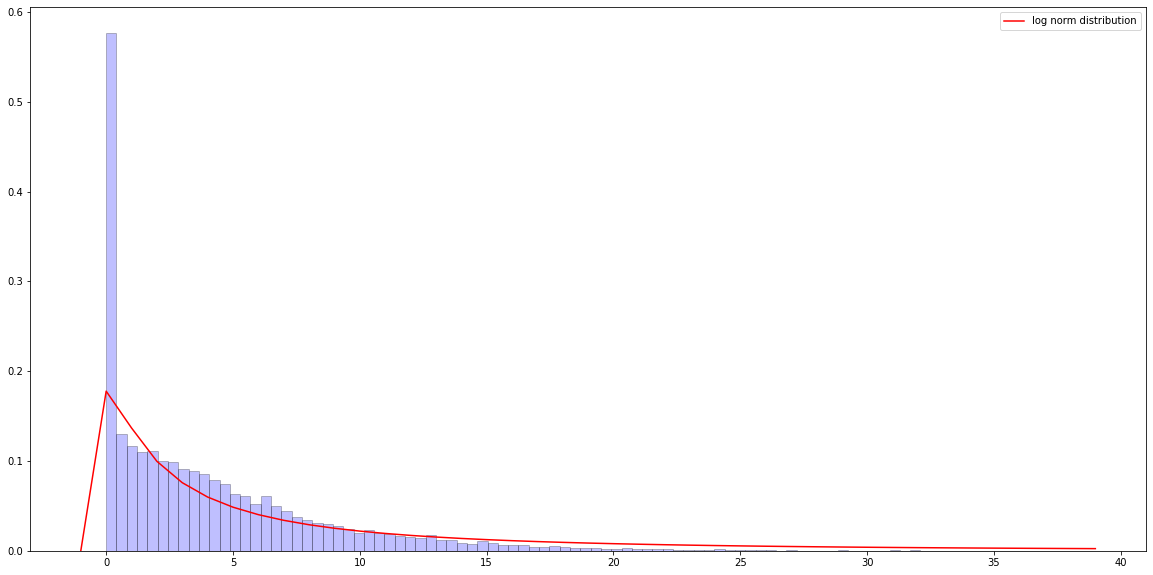

In [ ]:
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(df.windspeedAvg, bins='auto', density=True, facecolor='blue', alpha=0.25, edgecolor="k")
mu = df.windspeedAvg.mean()
sigma = df.windspeedAvg.std()
x = np.arange(-1,40,1)
y = stats.lognorm.pdf(x,1.5,(mu-sigma),sigma)  # lognorm.pdf(x, K, loc, scale)
plt.plot(x,y,'r-',label="log norm distribution")
plt.legend()
plt.show()

### Close(ish) but log norm drops off too fast - not a log normal distribution. Perhaps it's exponential?

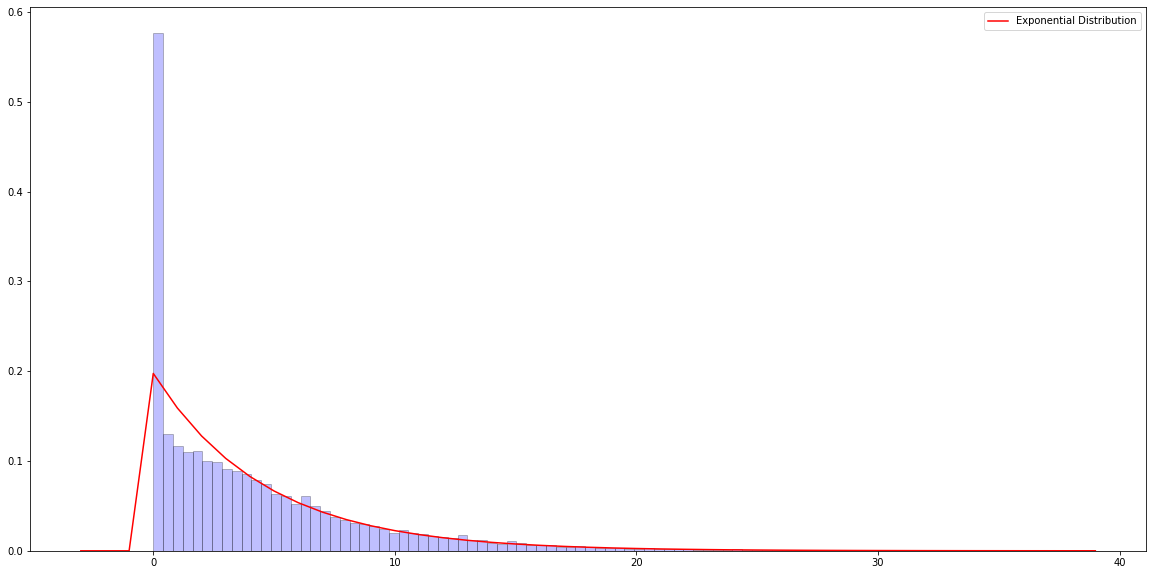

In [ ]:
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(df.windspeedAvg, bins='auto', density=True, facecolor='blue', alpha=0.25, edgecolor="k")
mu = df.windspeedAvg.mean()
sigma = df.windspeedAvg.std()
# print(sigma)
x = np.arange(-3,40,1)
y = stats.expon.pdf(x, loc=(mu-sigma), scale=sigma)
# y2 = stats.exponnorm.pdf(x,5,(mu-sigma),4) # pdf(x, K, loc, scale)
plt.plot(x,y,'r-',label='Exponential Distribution')
plt.legend()
plt.show()
# plt.plot(x,y2,'g-')

### Not perfect but it looks better than log norm.